Natural Language Inferencing (NLI) is a classic NLP (Natural Language Processing) problem that involves taking two sentences (the _premise_ and the _hypothesis_ ), and deciding how they are related- if the premise entails the hypothesis, contradicts it, or neither.

In this tutorial we'll look at the _Contradictory, My Dear Watson_ competition dataset, build a preliminary model using Tensorflow 2, Keras, and BERT, and prepare a submission file.

In [1]:
from transformers import BertTokenizer,TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [3]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

Let's set up our TPU.

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


## Downloading Data

The training set contains a premise, a hypothesis, a label (0 = entailment, 1 = neutral, 2 = contradiction), and the language of the text. For more information about what these mean and how the data is structured, check out the data page: https://www.kaggle.com/c/contradictory-my-dear-watson/data

In [5]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")

We can use the pandas head() function to take a quick look at the training set.

In [6]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


Let's look at one of the pairs of sentences.

In [7]:
train.premise.values[1]

'These are issues that we wrestle with in practice groups of law firms, she said. '

In [8]:
train.hypothesis.values[1]

'Practice groups are not permitted to work on these issues.'

In [9]:
train.label.values[1]

2

These statements are contradictory, and the label shows that.

Let's look at the distribution of languages in the training set.

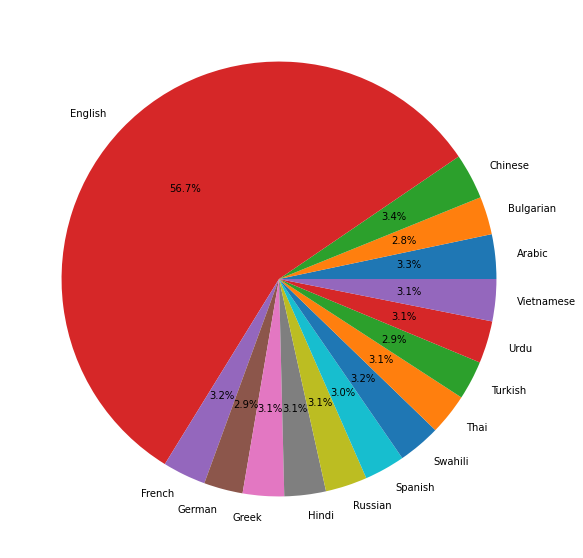

In [10]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

## Preparing Data for Input

To start out, we can use a pretrained model. Here, we'll use a multilingual BERT model from huggingface. For more information about BERT, see: https://github.com/google-research/bert/blob/master/multilingual.md

First, we download the tokenizer.

In [26]:
model_name = 'bert-base-multilingual-cased'
max_len =300
dropout=0.3
tokenizer = BertTokenizer.from_pretrained(model_name)

Tokenizers turn sequences of words into arrays of numbers. Let's look at an example:

In [31]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [32]:
def bert_encode(hypotheses, premises, tokenizer):
    
    num_examples = len(hypotheses)

    sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

    return inputs

In [33]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [34]:
max_len=train_input['input_word_ids'].shape[-1]
max_len

259

## Creating & Training Model

Now, we can incorporate the BERT transformer into a Keras Functional Model. For more information about the Keras Functional API, see: https://www.tensorflow.org/guide/keras/functional.

This model was inspired by the model in this notebook: https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert#BERT-and-Its-Implementation-on-this-Competition, which is a wonderful introduction to NLP!

In [35]:

def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
#     seq_op = tf.keras.layers.Dropout(dropout)(embedding[:,0,:]) 
#     seq_op = tf.keras.layers.Dense(64)(seq_op)
#     seq_op = tf.keras.layers.Dropout(dropout)(seq_op)
#     seq_op = tf.keras.layers.Dense(32)(seq_op) 
#     seq_op = tf.keras.layers.Dropout(dropout)(seq_op)
#     seq_op = tf.keras.layers.Dense(16)(seq_op) 
#     seq_op = tf.keras.layers.Dropout(dropout)(seq_op)
#     seq_op = tf.keras.layers.Dense(8)(seq_op)
#     seq_op = tf.keras.layers.Dropout(dropout)(seq_op)
#     output = tf.keras.layers.Dense(3, activation='softmax')(seq_op)
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [36]:
with strategy.scope():
    model = build_model()
    model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 259)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 259)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 259)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [40]:
callbacks=[tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0,
    mode='auto'
),tf.keras.callbacks.ModelCheckpoint(
    filepath='modelWeights.hdf5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)]

In [42]:
model.fit(train_input, train.label.values, epochs =30, verbose = 1, batch_size = 32, validation_split = 0.2, callbacks=callbacks)

Epoch 1/30
 35/303 [==>...........................] - ETA: 4:30 - loss: 1.0826 - accuracy: 0.4152

KeyboardInterrupt: 

In [ ]:
model.load_weights('modelWeights.hdf5')

In [ ]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [ ]:
test.head()

## Generating & Submitting Predictions

In [ ]:
predictions = [np.argmax(i) for i in model.predict(test_input)]

The submission file will consist of the ID column and a prediction column. We can just copy the ID column from the test file, make it a dataframe, and then add our prediction column.

In [ ]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission.csv", index = False)

And now we've created our submission file, which can be submitted to the competition. Good luck!